In [28]:
'''
USAGE:
python sparse_ae_kl.py --epochs 10 --reg_param 0.001 --add_sparse yes
'''
import torch
import torchvision
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import numpy as np
import argparse
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

import argparse
# constructing argument parsers 
ap = argparse.ArgumentParser()
ap.add_argument('--epochs', type=int, default=10,help='number of epochs to train our network for')
ap.add_argument('--reg_param', type=float, default=0.001, help='regularization parameter `lambda`')
ap.add_argument('--add_sparse', type=str, default='yes', help='whether to add sparsity contraint or not')
# args = vars(ap.parse_args())
args = ap.parse_args()

usage: ipykernel_launcher.py [-h] [--epochs EPOCHS] [--reg_param REG_PARAM]
                             [--add_sparse ADD_SPARSE]
ipykernel_launcher.py: error: unrecognized arguments: --ip=127.0.0.1 --stdin=9053 --control=9051 --hb=9050 --Session.signature_scheme="hmac-sha256" --Session.key=b"bfee21cc-7ddc-47f1-acd5-65474ff4fd1b" --shell=9052 --transport="tcp" --iopub=9054 --f=/opt/ml/.local/share/jupyter/runtime/kernel-v2-26295NiyCzv3DmTUr.json


SystemExit: 2

/opt/ml/input/.conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
EPOCHS = 1
BETA = 0.001
ADD_SPARSITY = 'yes'
RHO = 0.05
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
print(f"Add sparsity regularization: {ADD_SPARSITY}")

Add sparsity regularization: yes


In [ ]:
# image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])
trainset = datasets.MNIST(
    root='../input/data',
    train=True, 
    download=True,
    transform=transform
)
testset = datasets.MNIST(
    root='../input/data',
    train=False,
    download=True,
    transform=transform
)
 
# trainloader
trainloader = DataLoader(
    trainset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)
#testloader
testloader = DataLoader(
    testset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

100%|██████████| 9912422/9912422 [00:00<00:00, 26676508.04it/s]


Extracting ../input/data/MNIST/raw/train-images-idx3-ubyte.gz to ../input/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 260290.80it/s]


Extracting ../input/data/MNIST/raw/train-labels-idx1-ubyte.gz to ../input/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 7982487.42it/s]


Extracting ../input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../input/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5412082.04it/s]

Extracting ../input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../input/data/MNIST/raw



In [ ]:
# get the computation device
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()
# make the `images` directory
def make_dir():
    image_dir = '../outputs/images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
make_dir()
# for saving the reconstructed images
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)

In [ ]:
# define the autoencoder model
class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)

        # decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        z = F.relu(self.enc5(x))
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        return x,z
model = SparseAutoencoder().to(device)

In [ ]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# get the layers as a list
model_children = list(model.children())

In [ ]:
Linear(in_features=784, out_features=256, bias=True)
Linear(in_features=256, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=16, bias=True)
Linear(in_features=16, out_features=32, bias=True)
Linear(in_features=32, out_features=64, bias=True)
Linear(in_features=64, out_features=128, bias=True)
Linear(in_features=128, out_features=256, bias=True)

NameError: name 'Linear' is not defined

In [ ]:
def kl_divergence(rho, rho_hat):
    rho_hat = torch.mean(F.sigmoid(rho_hat), 1) # sigmoid because we need the probability distributions
    rho = torch.tensor([rho] * len(rho_hat)).to(device)
    return torch.sum(rho * torch.log(rho/rho_hat) + (1 - rho) * torch.log((1 - rho)/(1 - rho_hat)))
# define the sparse loss function
def sparse_loss(rho, images):
    values = images
    loss = 0
    for i in range(len(model_children)):
        values = model_children[i](values)
        loss += kl_divergence(rho, values)
    return loss

In [ ]:
# define the training function
def fit(model, dataloader, epoch):
    print('Training')
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(trainset)/dataloader.batch_size)):
        counter += 1
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        outputs,_ = model(img)
        mse_loss = criterion(outputs, img)
        if ADD_SPARSITY == 'yes':
            sparsity = sparse_loss(RHO, img)
            # add the sparsity penalty
            loss = mse_loss + BETA * sparsity
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / counter
    print(f"Train Loss: {epoch_loss:.3f}")
    # save the reconstructed images 
    save_decoded_image(outputs.cpu().data, f"../outputs/images/train{epoch}.png")
    return epoch_loss

In [ ]:
# define the validation function
def validate(model, dataloader, epoch):
    print('Validating')
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(testset)/dataloader.batch_size)):
            counter += 1
            img, _ = data
            img = img.to(device)
            img = img.view(img.size(0), -1)
            outputs,_ = model(img)
            loss = criterion(outputs, img)
            running_loss += loss.item()
    epoch_loss = running_loss / counter
    print(f"Val Loss: {epoch_loss:.3f}")  
    # save the reconstructed images 
    outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
    save_image(outputs, f"../outputs/images/reconstruction{epoch}.png")
    return epoch_loss

In [ ]:
# train and validate the autoencoder neural network
train_loss = []
val_loss = []
start = time.time()
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, trainloader, epoch)
    val_epoch_loss = validate(model, testloader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
end = time.time()
print(f"{(end-start)/60:.3} minutes")
# save the trained model
torch.save(model.state_dict(), f"../outputs/sparse_ae{EPOCHS}.pth")

Epoch 1 of 10
Training


100%|██████████| 1875/1875 [00:25<00:00, 72.79it/s]


Train Loss: 0.105
Validating


313it [00:01, 235.30it/s]                         


Val Loss: 0.090
Epoch 2 of 10
Training


100%|██████████| 1875/1875 [00:25<00:00, 74.40it/s]


Train Loss: 0.074
Validating


313it [00:01, 234.66it/s]                         


Val Loss: 0.056
Epoch 3 of 10
Training


100%|██████████| 1875/1875 [00:26<00:00, 71.06it/s]


Train Loss: 0.061
Validating


313it [00:01, 239.60it/s]                         


Val Loss: 0.053
Epoch 4 of 10
Training


100%|██████████| 1875/1875 [00:26<00:00, 71.47it/s]


Train Loss: 0.055
Validating


313it [00:01, 236.94it/s]                         


Val Loss: 0.047
Epoch 5 of 10
Training


100%|██████████| 1875/1875 [00:25<00:00, 74.01it/s]


Train Loss: 0.051
Validating


313it [00:01, 240.10it/s]                         


Val Loss: 0.044
Epoch 6 of 10
Training


100%|██████████| 1875/1875 [00:25<00:00, 74.03it/s]


Train Loss: 0.049
Validating


313it [00:01, 239.82it/s]                         


Val Loss: 0.042
Epoch 7 of 10
Training


100%|██████████| 1875/1875 [00:25<00:00, 73.48it/s]


Train Loss: 0.045
Validating


313it [00:01, 238.40it/s]                         


Val Loss: 0.039
Epoch 8 of 10
Training


100%|██████████| 1875/1875 [00:25<00:00, 73.26it/s]


Train Loss: 0.043
Validating


313it [00:01, 233.93it/s]                         


Val Loss: 0.038
Epoch 9 of 10
Training


100%|██████████| 1875/1875 [00:25<00:00, 74.98it/s]


Train Loss: 0.042
Validating


313it [00:01, 237.45it/s]                         


Val Loss: 0.037
Epoch 10 of 10
Training


100%|██████████| 1875/1875 [00:25<00:00, 72.58it/s]


Train Loss: 0.041
Validating


313it [00:01, 233.70it/s]                         

Val Loss: 0.036
4.5 minutes


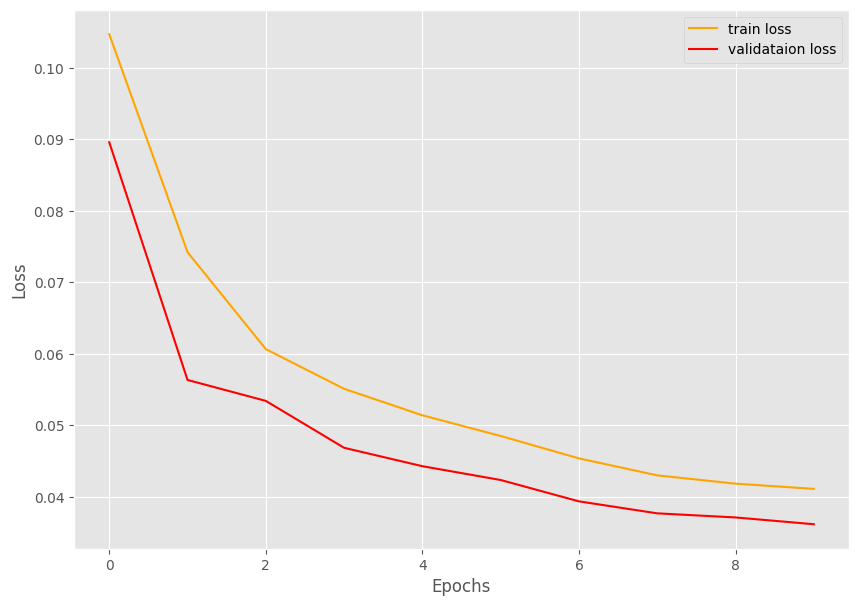

In [ ]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../outputs/loss.png')
plt.savefig('.loss.png')
plt.show()

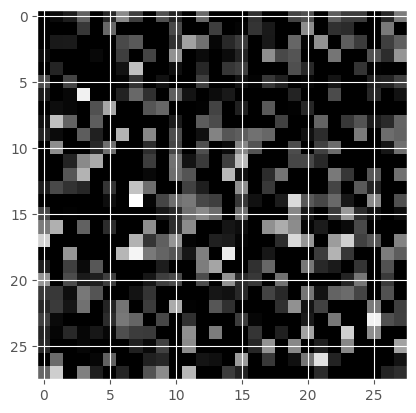

In [ ]:
model = SparseAutoencoder().to(device)
x = torch.randn(1, 784).to(device)  
x = x.view(x.size(0), -1)

y = model(x)
y = y.view(y.size(0), 1, 28, 28)
# show image
plt.imshow(y.cpu().detach().numpy().squeeze(), cmap='gray')
# save_image(y, '../outputs/sample_image.png')